In [1]:
import os
import glob

import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt

from invisible_cities.io  .pmaps_io      import load_pmaps
from invisible_cities.io  .mcinfo_io     import load_mchits
from invisible_cities.reco.xy_algorithms import corona

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 15

In [55]:
def make_track(hits):
    x = np.array([hit.X for hit in hits])
    y = np.array([hit.Y for hit in hits])
    z = np.array([hit.Z for hit in hits])
    e = np.array([hit.E for hit in hits])

    xt = []
    yt = []
    zt = []
    et = []
    
    zmin = min(z)
    zmax = max(z)
    while zmin <= zmax:
        indx  = (z >= zmin) & (z < zmin + 1)
        zmin += 1
        if np.count_nonzero(indx) == 0: continue

        xi = x[indx]
        yi = y[indx]
        ei = e[indx]
        zi = zmin - 0.5
        
        clusters = corona(np.stack((xi, yi), axis=1), ei, msipm=1, lm_radius=10, new_lm_radius=10, pitch=0)
        xt.extend([c.X for c in clusters])
        yt.extend([c.Y for c in clusters])
        zt.extend([zi  for c in clusters])
        et.extend([c.Q for c in clusters])
        
    return xt, yt, zt, et

In [30]:
filenames = glob.glob("/Users/Gonzalo/github/NEXTdata/MC/Th/runiv/pmaps/Tl208_NEW_v1_03_01_nexus_v5_03_04_UPPER_PORT_IC2610993_pmaps.*.h5")
pmaps     = {}
mc_hits   = {}
mc_tracks = {}
mc_energy = {}
for filename in filenames:
    pmaps.update(load_pmaps(filename))
    for evt_no, hits in load_mchits(filename).items():
        mc_hits  [evt_no] = hits
        mc_tracks[evt_no] = make_track(hits)
        mc_energy[evt_no] = sum(hit.E for hit in hits)

In [31]:
len(filenames), len(pmaps), len(mc_hits), len(mc_energy)

(129, 117379, 117379, 117379)

In [29]:
double_scape_limits = 1.590, 1.595
photopeak_limits    = 2.614, 2.615

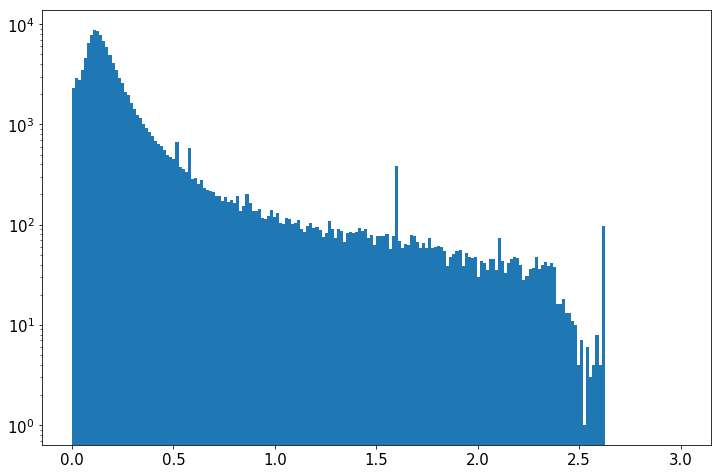

In [28]:
plt.hist(list(mc_energy.values()), np.linspace(0, 3, 201))
plt.yscale("log")

In [56]:
n = 0
for event_no, energy in mc_energy.items():
    if not (photopeak_limits[0] < energy < photopeak_limits[1]): continue
    n += 1
    if n > 1: break
    
    hits = mc_hits[event_no]
    trck = make_track(hits)
    x    = np.array([hit.X for hit in hits])
    y    = np.array([hit.Y for hit in hits])
    z    = np.array([hit.Z for hit in hits])
    e    = np.array([hit.E for hit in hits])

    plt.figure(figsize=(24,8))
    plt.subplot(1, 3, 1)
    plt.scatter(z, x, c="k", marker="x")
    plt.xlabel("z")
    plt.ylabel("x")

    plt.subplot(1, 3, 2)
    plt.scatter(z, y, c="k", marker="x")
    plt.xlabel("z")
    plt.ylabel("y")

    plt.subplot(1, 3, 3)
    plt.scatter(x, y, c="k", marker="x")
    plt.xlabel("x")
    plt.ylabel("y")

ClusterEmptyList: 